# Junction Reads (Adjacency Matrix) Analysis with SCANPY
This script demonstrates that junction-level count matrices, can yield meaningful cell embeddings using the SCANPY pipeline.

In [1]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
import anndata

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/mnt/data/kailu9/miniconda3/envs/DOLPHIN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==2.0.2 scipy==1.15.3 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.9.10 pynndescent==0.5.13


In [3]:
adata = sc.read_h5ad("/mnt/data/kailu9/DOLPHIN_run_input_output/DOLPHIN_tutorial/data/AdjacencyComp_fsla.h5ad")

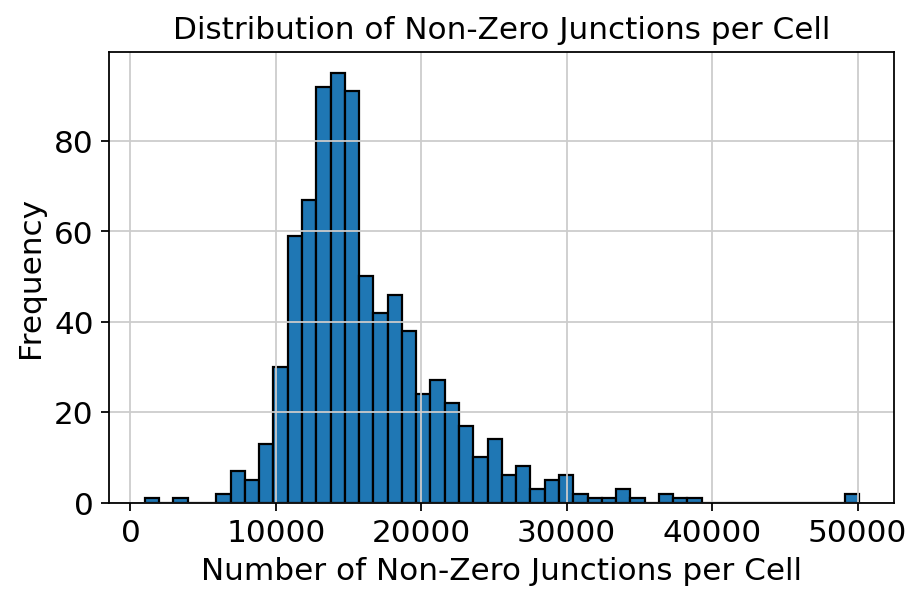

In [4]:
import matplotlib.pyplot as plt

df_adata = adata.to_df()
non_zero_counts = (df_adata != 0).sum(axis=1)
plt.figure(figsize=(6, 4))
plt.hist(non_zero_counts, bins=50, edgecolor='black')
plt.xlabel('Number of Non-Zero Junctions per Cell')
plt.ylabel('Frequency')
plt.title('Distribution of Non-Zero Junctions per Cell')
plt.tight_layout()
plt.show()


normalizing counts per cell
    finished (0:00:00)


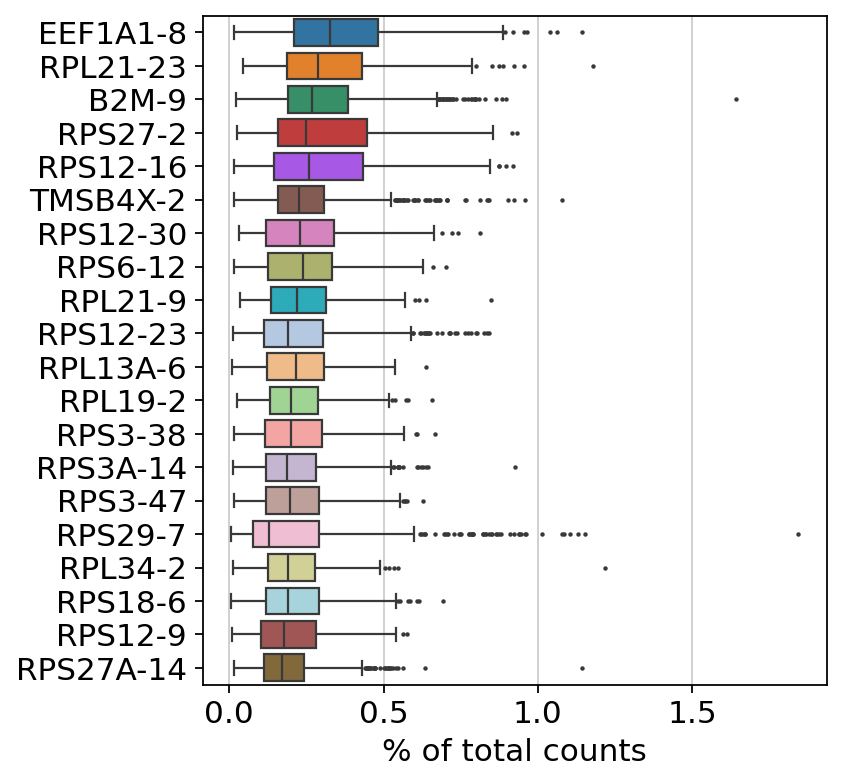

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [6]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 6284013 genes that are detected in less than 3 cells


In [10]:
adata.var["mt"] = adata.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

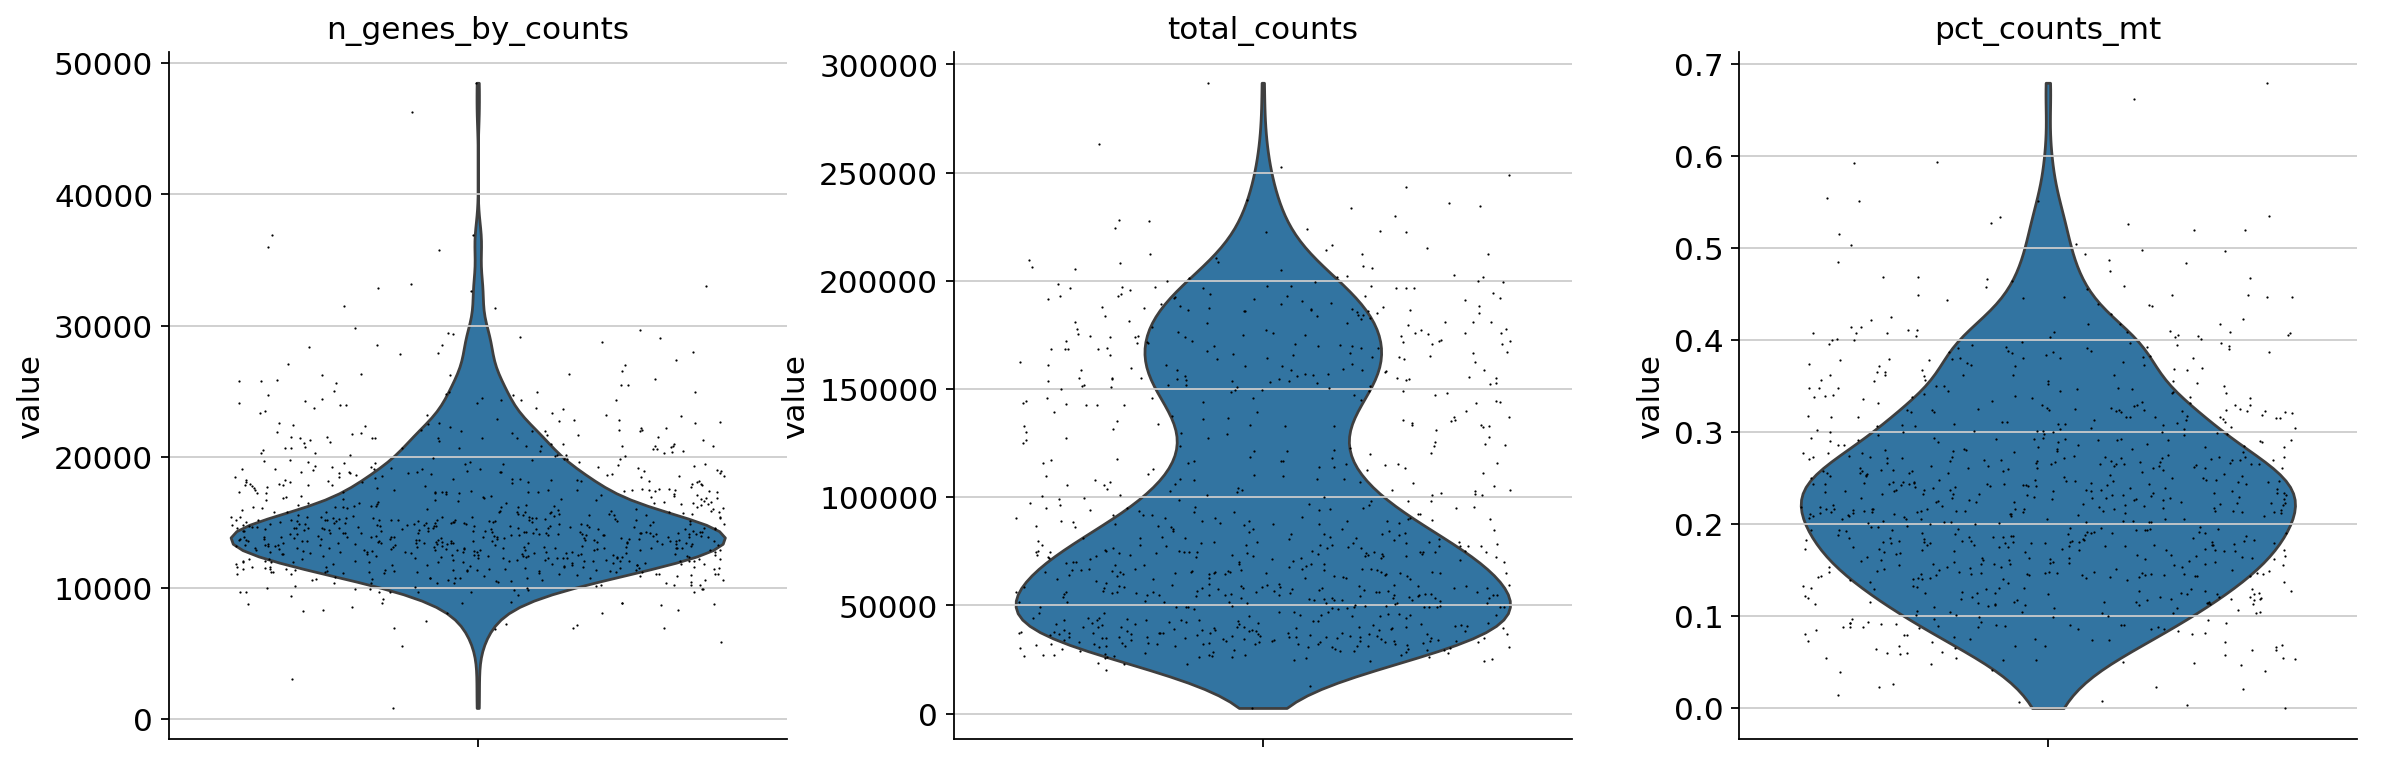

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

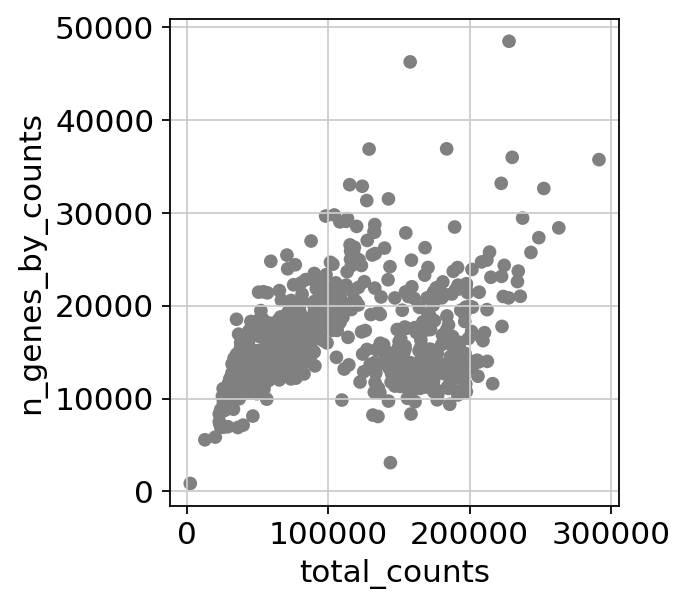

In [12]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
sc.pp.normalize_total(adata)

normalizing counts per cell
    finished (0:00:00)


In [14]:
adata

AnnData object with n_obs × n_vars = 795 × 245231
    obs: 'CB', 'celltype1', 'celltype2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [15]:
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

extracting highly variable genes


/mnt/data/kailu9/miniconda3/envs/DOLPHIN/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/mnt/data/kailu9/miniconda3/envs/DOLPHIN/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


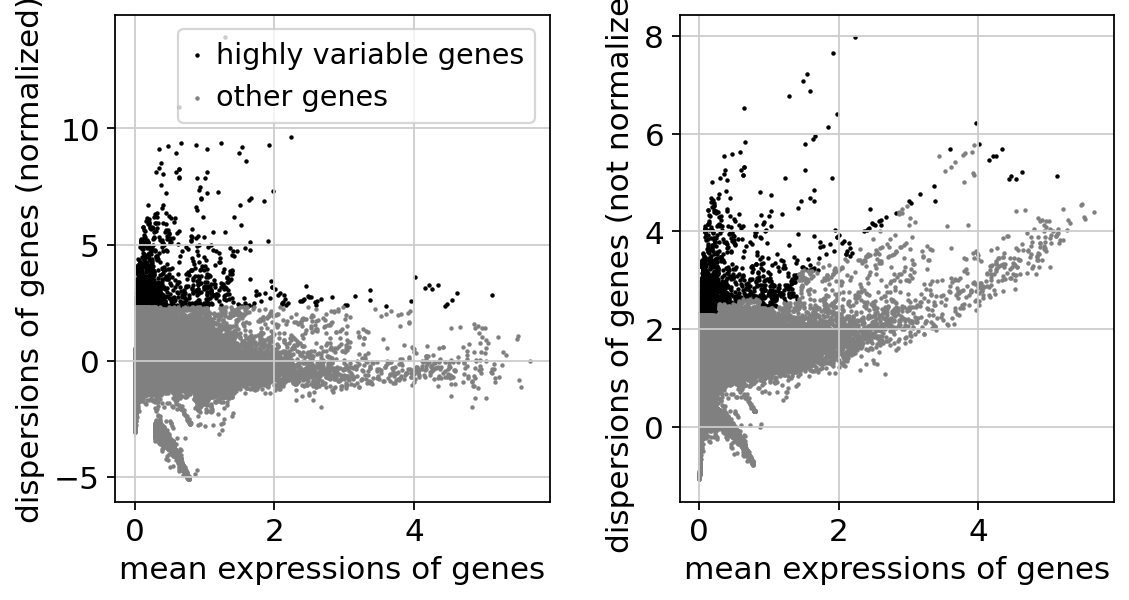

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
adata.raw = adata

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']


/mnt/data/kailu9/miniconda3/envs/DOLPHIN/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:00:15)


In [21]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:19)


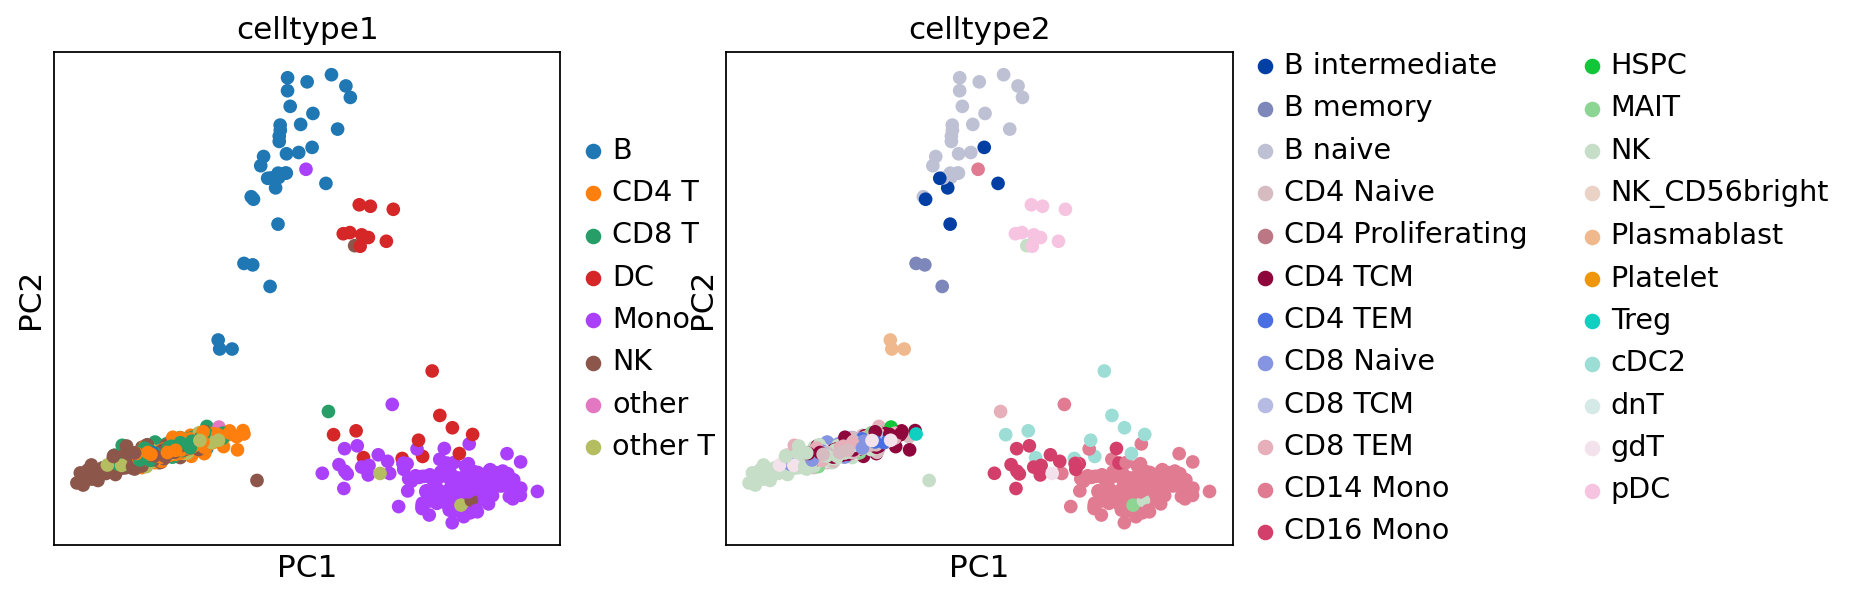

In [22]:
sc.pl.pca(adata, color=["celltype1", "celltype2"])

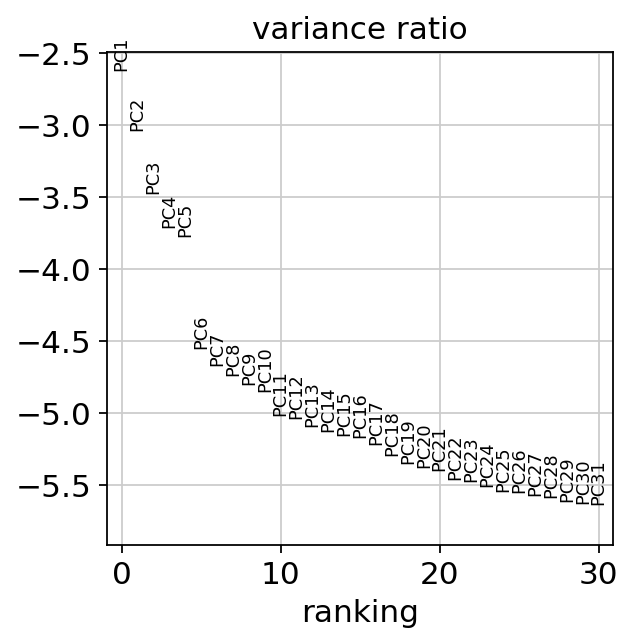

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [25]:
## choose the resolution which produce the same number of clusters as the celltype1
for res in np.arange(0.0,2,0.01):
    sc.tl.leiden(adata, res)
    if len(set(adata.obs["leiden"])) == len(set(adata.obs["celltype1"])):
        break

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/tmp/ipykernel_885040/1209000394.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, res)


running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 cluster

In [26]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


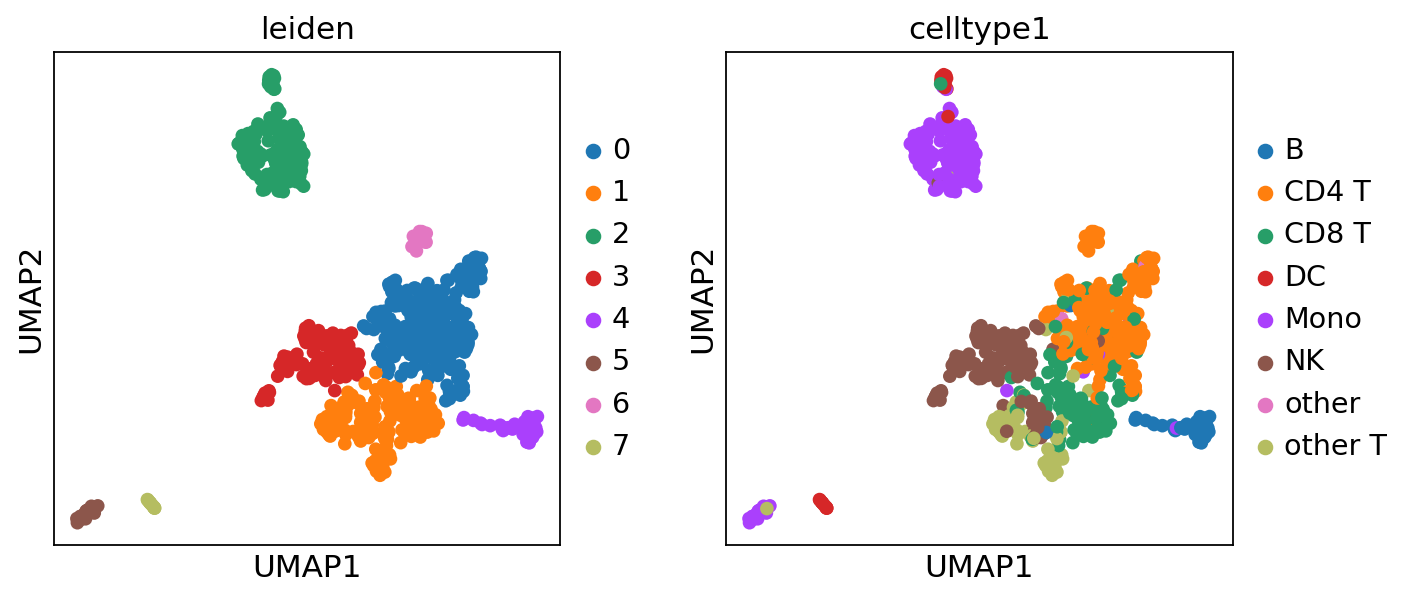

In [30]:
sc.pl.umap(adata, color=["leiden", "celltype1"])